### adma 등 공부 정리 사이트 https://blog.naver.com/bosongmoon/221794898136

### 글자프레임 이용하기

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy
import os

In [3]:
#데이터 불러오기
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() #학습 데이터와 테스트 데이터를 불러오기
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255 #mask로 만들것이기 때문에, 28x28에 흑백이기 때문에 1개 (칼라 - RGB -> 3)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255 

Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)


In [4]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(60000, 10000, 60000, 10000)

In [5]:
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Dropout

# 컨볼루션 신경망의 설정
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu')) #Conv2D()사용.  # Conv1D() 1차원 # Conv3D() 3차원 
#dense에서는 input_dim()을 사용하였으나, mask에서는 input_shape을 사용 --> code  3x3의 커널(또는 mask)를 32개(즉, 출력이 32개)를 사용한다.
# -> 서로 다른 특징을 찾아내기 위해서 여러가지의 커널을 사용한다.(귀 / 눈/ 머리 등등)
#너무 많은 mask를 사용하면 불필요한 데이터 출력과 속도가 느려지는 등의 문제가 발생.

#일반적인 이미지 convolution에서는  mask의 내용을 알고 있으며, 원하는 값을 추출하거나 할 수 있지만
#딥러닝의 convolution mask는 mask의 정보를 알지 못하고, 가중치 파라미터의 역할을 한다고 생각하면 된다.



model.add(Conv2D(64, (3, 3), activation='relu'))
# 3x3개의 마스크를 64개(= 출력)사용.



model.add(MaxPooling2D(pool_size=2))
#
# 특징을 뽑아내려면 MaxPooling을 사용
# Pool_Size = 2 / 이미지의 사이즈가 절반으로 줄어들고 특징만 추출함. 

  - ### MaxPooling
      - 추출한 이미지 크기가 크고 복잡할 때, 이를 다시 한번 축소하는 과정. 풀링 또는 서브 샘플링이라고 한다. max_pooling / average_pooling 2가지가 있다.
      - Pool_Size = 2 / 이미지의 사이즈가 절반으로 줄어들고 특징만 추출함. 
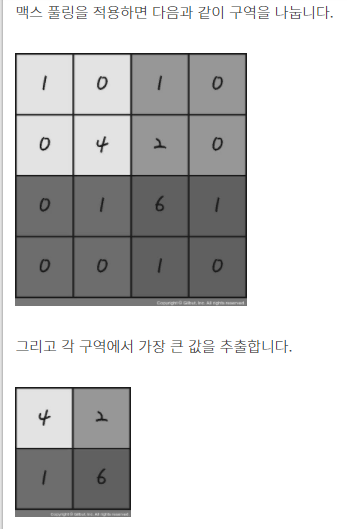

In [6]:
model.add(Dropout(0.25)) # 전체 노드 중 1/4를 끄겠다.
#과적합을 피하기 위해 은닉층에 배치된 노드 중 일부를 임의로 꺼준다.

   - ### 드롭아웃
       - 과적합을 피하기 위해 은닉층에 배치된 노드 중 일부를 임의로 꺼준다.
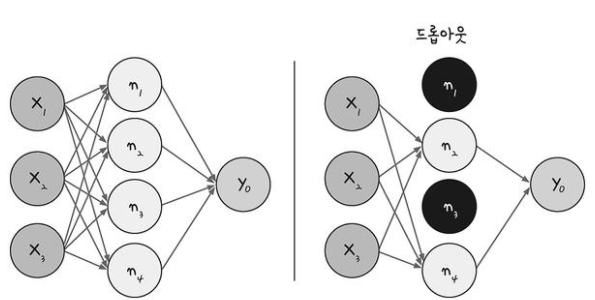

In [7]:
model.add(Flatten()) # flatten() : 데이터 배열이 몇차원이던간에, 1차원으로 줄여주는 함수.
model.add(Dense(128,  activation='relu')) #은닉층 노드 
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # 출력층 노드
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


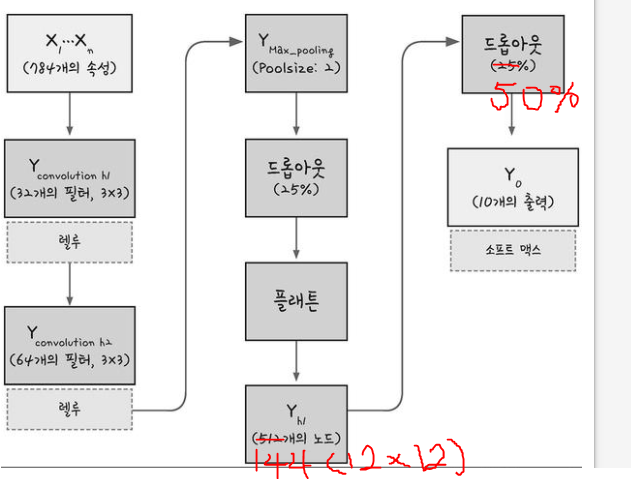

#

  - 1층 모델 : 가중치 파라미터 3x3x32 = 288/ 바이오스 파라미터 32개, 합 = 320개 (26 , 26, 32) 
      - 가중치 : 커널 사이즈 3x3 = 9. 1x3x3x32 = 288 / 바이오스 32개 = 320 -->하나의 이미지 데이터를 커널을 통해 컨볼루션 해준다고 생각하면 됌
      - 1층 모델이 일반적으로 사용하는 Dense층 일 때에는 입력에 따라 가중치 파라미터가 발생, 이미지를 사용하는 Conv2D 일 때에는 커널과 커널의 개수로 보면 된다.
  - 2층 모델 : 가중치 파라미터 32 (입력)* 9(커널) * 64 = 18,432개/ 바이오스 파라미터 64개, 합 = 18,496개
  - 3층 모델 (Max_pooling) : 이미지를 절반으로 축소 (12, 12, 64)
  - 4층 모델 (Flatten) : 12*12 를 1차원으로 변경  12 * 12 = 144개의 픽쳐
  - 5층 모델 : 가중치 파라미터 12*12(이미지) * 64(입력) * 128(출력) = 1,179,648개 / 바이오스 파라미터 128개. 합 = 1,179,776개
  - 6층 모델 : 가중치 파라미터 128*10 = 1280개 / 바이오스 파라미터 10개. 합 = 1290개


  - Conv2d가 진행이되면서 이미지가 상하 좌우 한 칸씩에는 커널이 적용하지 못해서 이미지 크기가 줄어든다.
      -  이미지 : (28,28,1) ->  (26,26,1) -> (24,24,1)


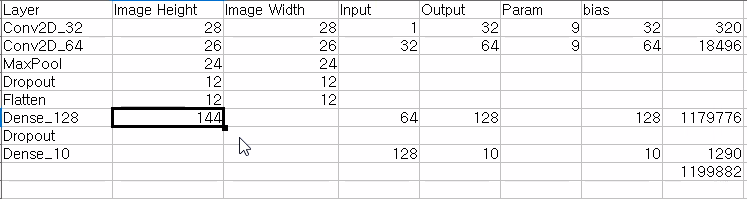

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [9]:
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [10]:
# 모델의 실행
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=200, verbose=0, callbacks=[early_stopping_callback,checkpointer])


Epoch 00001: val_loss improved from inf to 0.05308, saving model to ./model\01-0.0531.hdf5

Epoch 00002: val_loss improved from 0.05308 to 0.03853, saving model to ./model\02-0.0385.hdf5

Epoch 00003: val_loss improved from 0.03853 to 0.03226, saving model to ./model\03-0.0323.hdf5

Epoch 00004: val_loss improved from 0.03226 to 0.02908, saving model to ./model\04-0.0291.hdf5

Epoch 00005: val_loss did not improve from 0.02908

Epoch 00006: val_loss did not improve from 0.02908

Epoch 00007: val_loss improved from 0.02908 to 0.02833, saving model to ./model\07-0.0283.hdf5

Epoch 00008: val_loss improved from 0.02833 to 0.02778, saving model to ./model\08-0.0278.hdf5

Epoch 00009: val_loss did not improve from 0.02778

Epoch 00010: val_loss did not improve from 0.02778

Epoch 00011: val_loss did not improve from 0.02778

Epoch 00012: val_loss did not improve from 0.02778

Epoch 00013: val_loss improved from 0.02778 to 0.02764, saving model to ./model\13-0.0276.hdf5

Epoch 00014: val_lo

In [11]:
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))


313/313 [==============================] - 1s 4ms/step - loss: 0.0334 - accuracy: 0.9927

 Test Accuracy: 0.9927


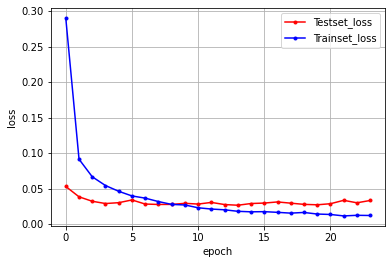

In [12]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 딥러닝을 이용한 자연어 처리
  - 입력된 텍스트를 잘게 나누는 과정을 토큰화(tokenization)
  - 케라스가 제공하는 text 모듈의 text_to_word_sequence() 함수를 사용 / 문장을 단어 단위로 쉽게 나눌 수 있다.

In [ ]:
import tensorflow as tf
import numpy 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding


In [ ]:
#케라스의 텍스트 전처리와 관련한 함수중 text_to_word_sequence 함수를 불러 옵니다.
from tensorflow.keras.preprocessing.text import text_to_word_sequence
 
# 전처리할 텍스트를 정합니다.
text = '해보지 않으면 해낼 수 없다'
 
# 해당 텍스트를 토큰화 합니다.
result = text_to_word_sequence(text)
print("\n원문:\n", text)
print("\n토큰화:\n", result)

In [ ]:
# Bag-of-Words라는 방법이 이러한 전처리를 일컫는 말인데, ‘단어의 가방(bag of words)’이라는 말 뜻 그대로, 같은 단어끼리 따로따로 가방에 담은 뒤 각 가방에 몇 개의 단어가 들어있는지를 세는 기법
# 케라스의 Tokenizer() 함수를 사용하면 단어의 빈도 수를 쉽게 계산할 수 있다.
docs = ['먼저 텍스트의 각 단어를 나누어 토큰화 합니다.',
       '텍스트의 단어로 토큰화 해야 딥러닝에서 인식됩니다.',
       '토큰화 한 결과는 딥러닝에서 사용 할 수 있습니다.',
       ]

# 토큰화 함수를 이용해 전처리 하는 과정입니다.
token = Tokenizer()             # 토큰화 함수 지정
token.fit_on_texts(docs)       # 토큰화 함수에 문장 적용


In [ ]:
#단어의 빈도수를 계산한 결과를 각 옵션에 맞추어 출력합니다. 
 
print("\n단어 카운트:\n", token.word_counts) 

In [ ]:
#출력되는 순서는 랜덤입니다. 
print("\n문장 카운트: ", token.document_count)
print("\n각 단어가 몇개의 문장에 포함되어 있는가:\n", token.word_docs)
print("\n각 단어에 매겨진 인덱스 값:\n",  token.word_index) #인덱스의 순서는 빈도수가 높은 순서대로 매겨주며, 빈도수가 같은 경우, 문장의 배열 순대로 계싼 된다. 

In [ ]:
# 단어가 문장의 다른 요소와 어떤 관계를 가지고 있는지를 알아보는 방법이 필요하여, 가장 기본적인 방법인 원-핫 인코딩(one-hot encoding)을 사용
text = "오랫동안 꿈꾸는 이는 꿈을 닮아간다"
token = Tokenizer()
token.fit_on_texts([text])
print(token.word_index)

In [ ]:
x= token.texts_to_sequences([text])#인덱스를 뽑아낸다.

In [ ]:
x

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
word_size = len(token.word_index) + 1 

In [ ]:
x = to_categorical(x, num_classes= word_size) # 원-핫-인코딩을 사용한다.

print(x)

  -  원-핫 인코딩을 그대로 사용하면, 벡터의 길이가 너무 길어진다는 단점이 있다.
  -  이러한 공간적 낭비를 해결하기 위해 등장한 것이 ' 단어 임베딩 ' 

  -  임베딩 --> 고차원의 희소 벡터를 저차원의 밀집벡터로 바꿔주는 것
     -  단어를 연관성로 구분하여(빈도수, 비슷한 단어 등) 벡터 값을 유사하게 정해준다. --> 단어 임베딩
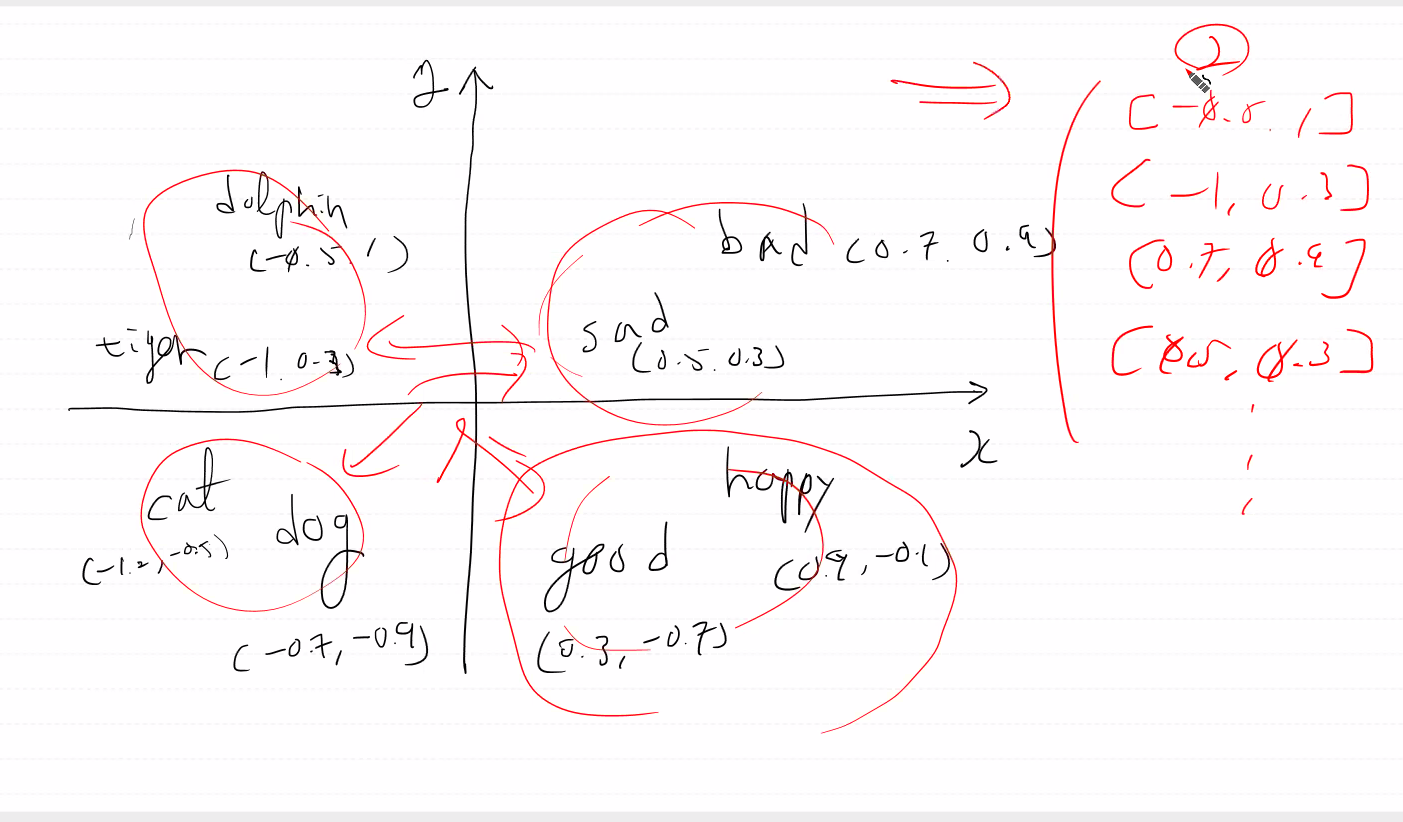

In [ ]:
from tensorflow.keras.layers import Embedding
# 임베딩 함수 자체가 내부적으로 임베딩을 통해 저차원 밀집벡터로 바꾸어준다

model = Sequential()
model.add(Embedding(16,4)) #Embedding(x,y, input_length=2) -P  x : 총 단어의 수 / y : 몇차원으로 바꿔줄 것인가? 매번 2개씩 넣겠다.
#--> number of samples (샘플수 ) = 1 , input-length = 2, word-dimension(차원) =4  1 * (2 * 4) = 8 --> 출력 될 때 배열 형태

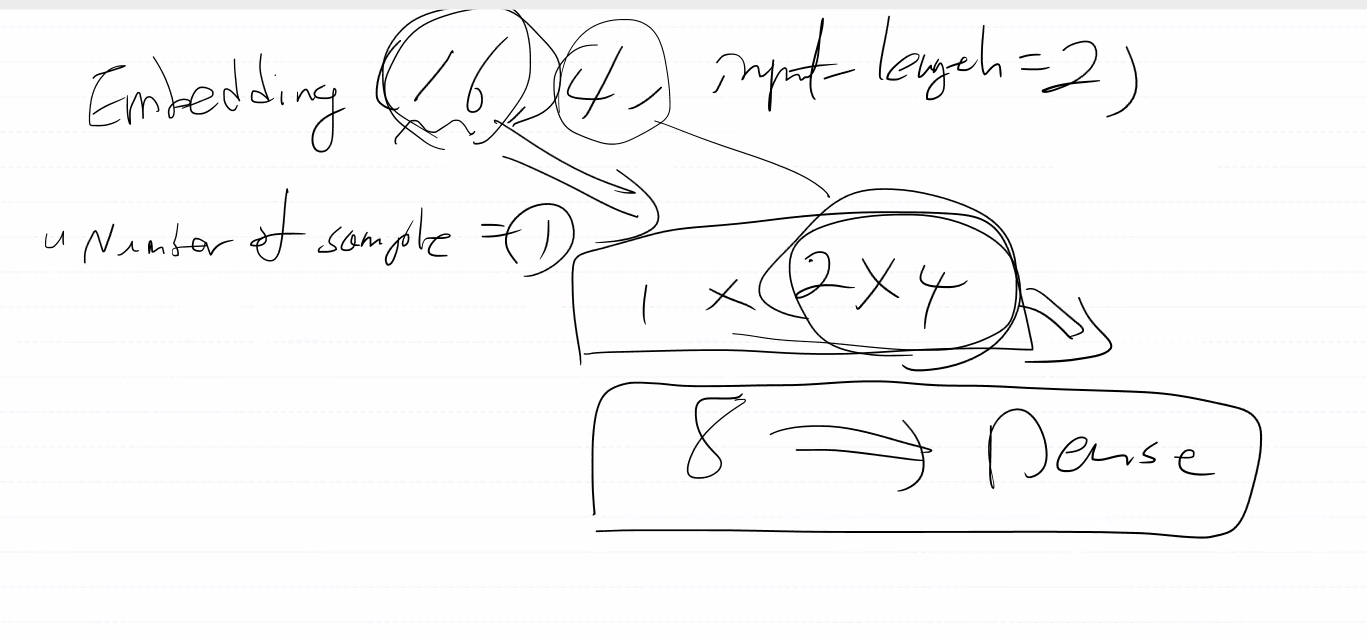

In [ ]:
print("\n각 단어가 몇개의 문장에 포함되어 있는가:\n", token.word_docs)
print("\n각 단어에 매겨진 인덱스 값:\n",  token.word_index)


# 텍스트 리뷰 자료를 지정합니다.
docs = ["너무 재밌네요","최고예요","참 잘 만든 영화예요","추천하고 싶은 영화입니다","한번 더 보고싶네요","글쎄요","별로예요","생각보다 지루하네요","연기가 어색해요","재미없어요"]


In [ ]:
from numpy import array
# 긍정 리뷰는 1, 부정 리뷰는 0으로 클래스를 지정합니다.
classes = array([1,1,1,1,1,0,0,0,0,0])

In [ ]:
# 토큰화 함수를 이용해 전처리 하는 과정입니다.
token = Tokenizer()             # 토큰화 함수 지정
token.fit_on_texts(docs)       # 토큰화 함수에 문장 적용
#단어의 빈도수를 계산한 결과를 각 옵션에 맞추어 출력합니다. 
 
print("\n단어 카운트:\n", token.word_counts) 

In [ ]:
print(token.word_index)

In [ ]:
x = token.texts_to_sequences(docs)
print("\n리뷰 텍스트, 토큰화 결과:\n",  x)

In [ ]:
# 임의로 길이를 맞춰줄 수 있다. 패딩(padding). 길이보다 짧은 부분은 0을 넣어서 채워주고, 긴 데이터는 잘라준다.
# 함수 pad_sequence()를 사용한다.

from tensorflow.keras.preprocessing.sequence import pad_sequences
# 패딩, 서로 다른 길이의 데이터를 4로 맞추어 줍니다.
padded_x = pad_sequences(x, 4)  
print("\n패딩 결과:\n", padded_x)


In [ ]:
#딥러닝 모델
print("\n딥러닝 모델 시작:")

#임베딩에 입력될 단어의 수를 지정합니다.
word_size = len(token.word_index) +1
 
#단어 임베딩을 포함하여 딥러닝 모델을 만들고 결과를 출력합니다.
model = Sequential()
model.add(Embedding(word_size, 8, input_length=4))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(padded_x, classes, epochs=20)
print("\n Accuracy: %.4f" % (model.evaluate(padded_x, classes)[1]))

In [ ]:
word_size

  - 1층 모델 : Embedding(21, 8, input_length=4)) =>  word_size는 21이지만 입력은 20개
             : 가중치 : 최초 전체입력 * (출력벡터의 차원) /  바이오스 = (출력 벡터의 차원)
             : 가중치 파라미터 20(입력) * 8(출력) = 160개 / 바이오스 파라미터 8개. 합 168개 
  - 2층 모델 (Flatten) -> 배열 : 4 * 8 행렬을 1차원 배열로 변경 -> 4*8 = 32 
  - 3층 모델 : 가중치 파라미터 : 32(1차원의 32픽쳐) * 1(출력) = 32개 / 바이오스 파라미터 1개. 합 = 33개

  - 20개의 단어를 4개씩 자르게 되면, 5개의 샘플로 분류가 된다. desen은 4*8 = 32개가 되며 이는 출력되는 행렬의 배열 모습이다
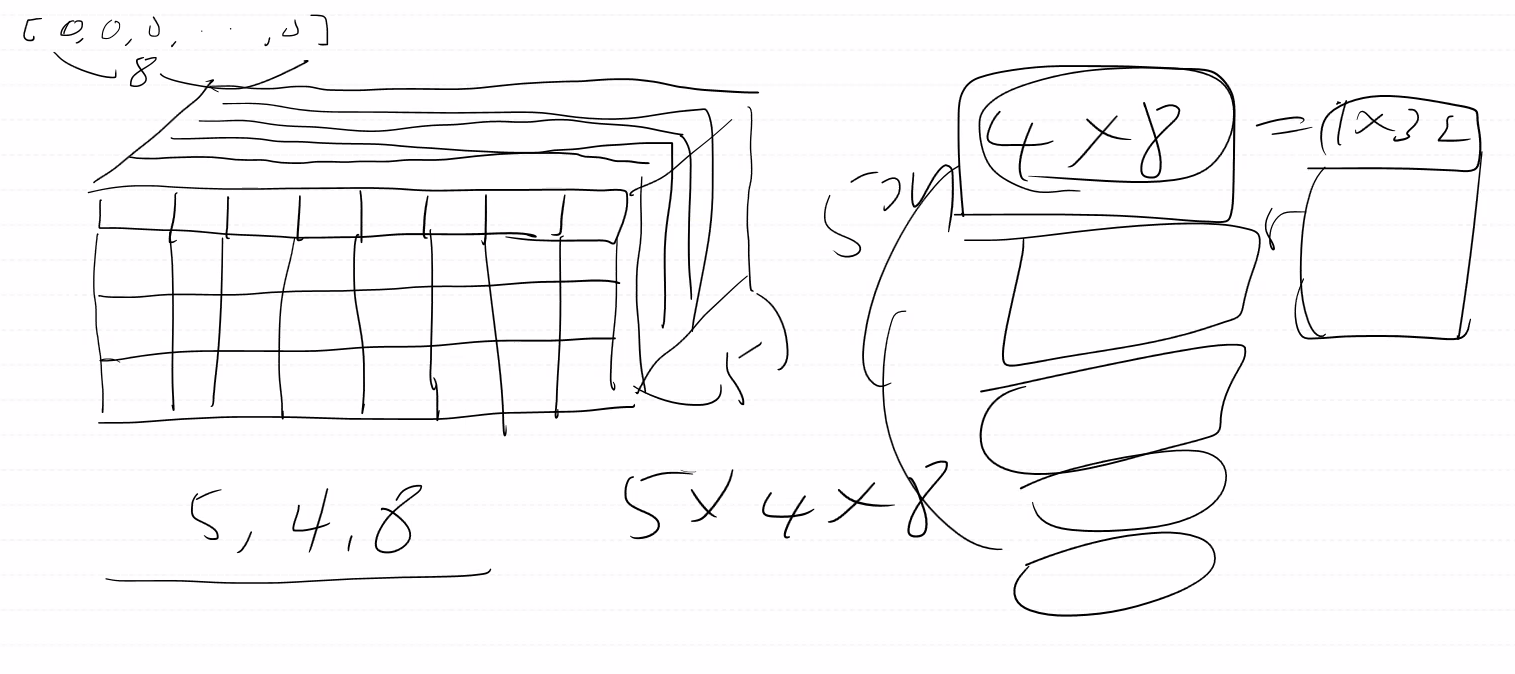

## 시퀸스 배열로 다루는 순환 신경망 (RNN)
  - 과거에 입력된 데이터와 나중에 입력된 데이터 사이의 관계를 고려해야하는 문제가 발생
  - -> 순환 신경망 이라는 방법이 고안됨.
  - 순환 신경망 : 데이터가 순서되로 입력되었을 때
  순환 신경망은 여러 개의 데이터가 순서대로 입력되었을 때 앞서 입력받은 데이터를 잠시 기억해 놓는 방법입니다. 그리고 기억된 데이터가 얼마나 중요한지를 판단하여 별도의 가중치를 줘서 다음 데이터로 넘어갑니다. 모든 입력 값에 이 작업을 순서대로 실행하므로 다음 층으로 넘어가기 전에 같은 층을 맴도는 것처럼 보입니다. 이렇게 같은 층 안에서 맴도는 성질 때문에 순환 신경망(이하 RNN)이라고 부릅니다.
  

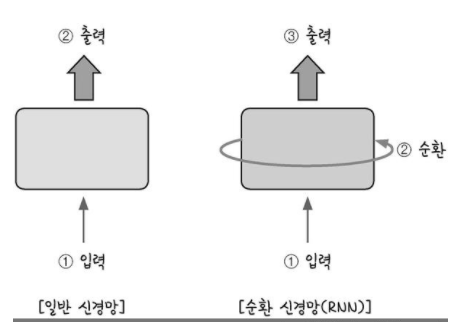
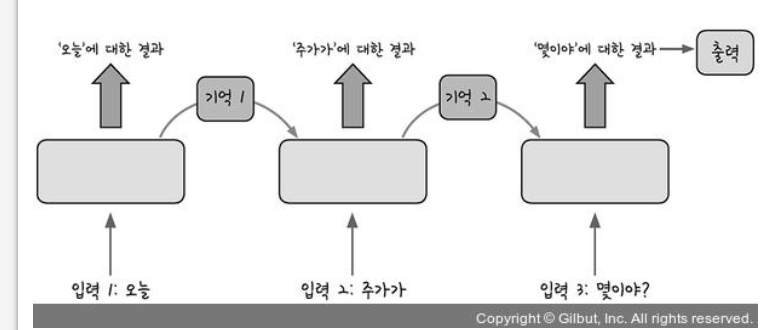

  - 어제와 오늘, 주가의 비교
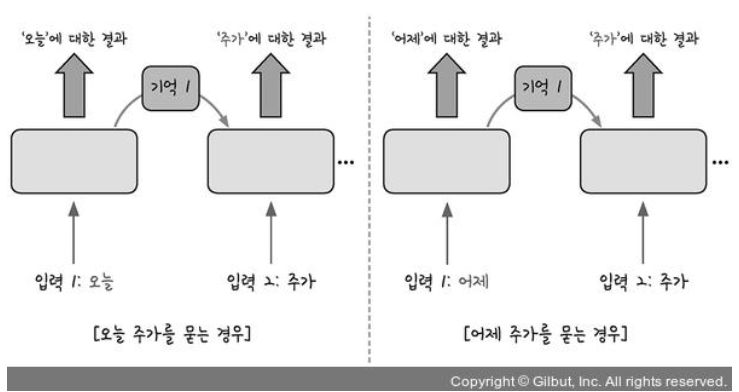
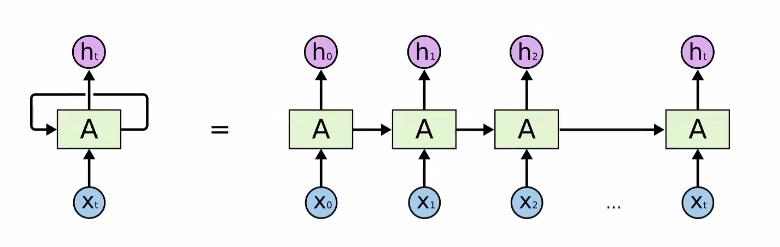

  - 문장이 길면 길 수록, 계속적인 미분으로 기울기 값이 소실되는 문제가 있다.
  - 같은 가중치 형태로 들어오기 때문에, 장기 기억 문제 발생.
  - LSTM으로 문제를 조치. LSTM(Long-Short term Memory)

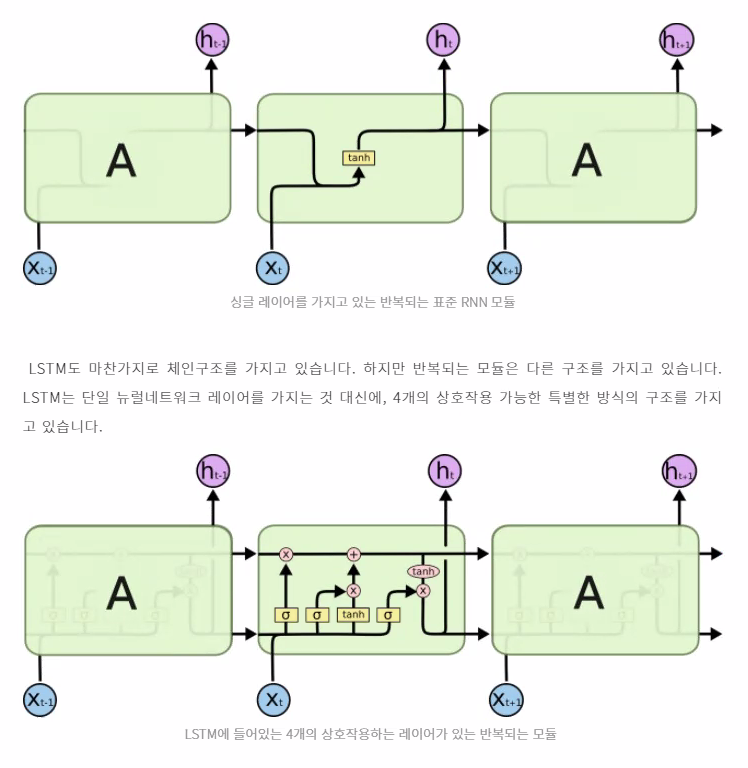

 - 기억 전달 셀
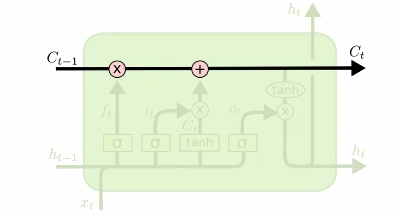

- 행렬 곱셈

- 포겟 게이트 (필요성에 따라 없으면 0, 있으면 1의 값을 입력하여 곱셈 실시)
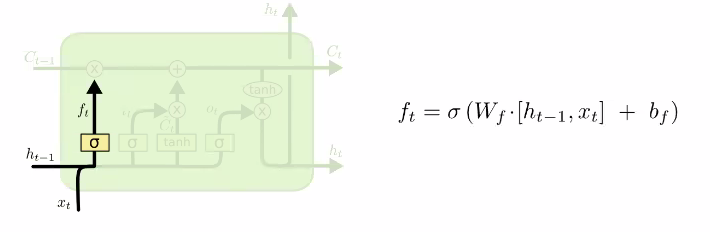

- 선별된 데이터를 적용 시키기
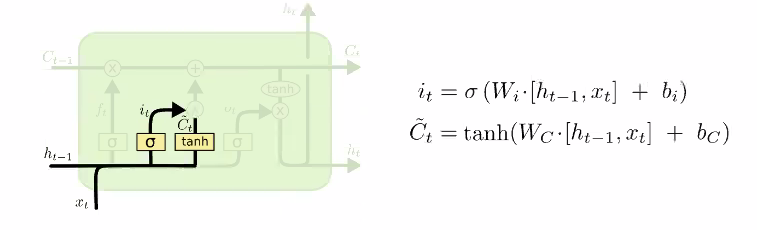

In [ ]:
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import utils

In [ ]:
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=1000, test_split=0.2) # 단어의 빈도수가 1000개 이상인 것만 가져오기. test 데이터는 20%로 잡기. 

In [ ]:

# 데이터 확인하기
category = numpy.max(Y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

In [ ]:
x_train = sequence.pad_sequences(X_train, maxlen=100) #100개 기준으로 길이를 맞추기
x_test = sequence.pad_sequences(X_test, maxlen=100)

In [ ]:
y_train = utils.to_categorical(Y_train)
y_test = utils.to_categorical(Y_test)

In [ ]:
print(y_train[0])

In [ ]:
# 모델의 설정
model = Sequential()
model.add(Embedding(1000, 100)) #입력 1000, 100차원 
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 컴파일
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
model.summary()

  - 1층 모델 : Embedding(1000,100) => 가중치 :  999 * 100 = 99,900 / bias : 100 합 100,000
  - 2층 모델 : LSTM의 파라미터 : 4 * ((size_of_input +1(=bias))*size_of_output+size_of_output^2)
             : 4 * ((100 + 1)*(100) + (100)^2) = 80400
  - 3층 모델 : 100 * 46 + 46 = 4646개

In [ ]:

# 모델의 실행
history = model.fit(x_train, y_train, batch_size=100, epochs=20, validation_data=(x_test, y_test))

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))


In [ ]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
w= model.get_weights()[0] # 가중치

In [ ]:
w

In [ ]:
b= model.get_weights()[1] # bias

In [ ]:
b

## Lstm과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [10]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
import os

In [11]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\thcho\.conda\envs\dl_env\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\thcho\.conda\envs\dl_env\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

In [12]:
x_train = sequence.pad_sequences(x_train, maxlen=100) #크기 조정
x_test = sequence.pad_sequences(x_test, maxlen=100)

In [13]:
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1)) #mask가 1행렬인 5이기 때문에 좌, 우측 각 2개씩 잘리게 되지만, padding 을 이용하여 크기는 유지하나 값을 0으로 채워준다.
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()
# 모델의 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         500000    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 55)                26400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 56        
_________________________________________________________________
activation (Activation)      (None, 1)                

  - 1층 모델 : Embedding(5000*100)) => 가중치 : 4999*100, 바이오스 : 100, 합 = 500,000개
  - 2층 모델 : 드랍아웃. 파라미터에  영향 x
  - 3층 모델 conv1d -> 가중치 : 100 * 1 x 5 x 64 / 바이오스 : 64. 합 : 32,064개
  - 4층 모델 : MaxPooing1D. 파라미터에 영향 x.
  - 5층 모델 : 4 * ((size_of_input +1(=bias))*size_of_output+size_of_output^2) = 4((64+1)*55 + 55^2) = 26400
  - 6층 모델 : 가중치 파라미터 55*1 = 55개 / 바이오스 파라미터 1개. 합 = 56개
  
  - 모델 총 합계 : 558,520개

In [ ]:
# 모델의 실행
history = model.fit(x_train, y_train, batch_size=100, epochs=5, validation_data=(x_test, y_test))

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))


# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
